In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%; font-weight: bold}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%;}</style>"))

In [2]:
import pickle
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
import pandas as pd
import os
import time, os
import pymysql
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import ta
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

warnings.filterwarnings(action='ignore')



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15,7)

Populating the interactive namespace from numpy and matplotlib


In [3]:
from itertools import combinations
len(list(combinations(range(5000), 2)))

12497500

# ccI

## train data 생성 함수

In [3]:
def make_data_train_cci(trading=100000000, cci_d='_', days=10, label=0.02): 
    # traiding: 거래대금 임계값, ma: 이동평균 20일 범위, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # trainX, trainY
    lst_trainX = []
    lst_trainY = []
    
    # next_change, code, date
    lst_nc = []  
    lst_cd = []
    lst_dt = []
    
    # database
    db_dsml = pymysql.connect(

    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
       
    temp_cci_d = cci_d
    
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2017-01-01' AND '2020-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()

        if temp_cci_d == '_': 
            cci_d = stock['CCI'].min()

        
        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, cci_ = row[0].strftime('%Y%m%d'), row[4], row[5], row[40]
            # 거래대금, cci 범위 조건

            if (close * volume >= trading) & (cci_ >= cci_d):
                if i < (days-1):   # 예외 처리 
                    continue                               
                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_trainX.append(result)
                lst_trainY.append(y)
                lst_nc.append(row[7])
                lst_cd.append(code)
                lst_dt.append(date)
    
    return np.array(lst_trainX), np.array(lst_trainY), np.array(lst_nc), lst_cd, lst_dt 

## test data 생성 함수 

In [4]:
def make_data_test_cci(trading=100000000, cci_d='_', days=10, label=0.02): 
    # traiding: 거래대금 임계값, ma: 이동평균 20일 범위, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # testX, testY
    lst_testX = []
    lst_testY = []
    
    # next_change
    lst_nc_test = []
    lst_cd_test = []
    lst_dt_test = []
    
    # database
    db_dsml = pymysql.connect(

    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
    
    temp_cci_d= cci_d
    
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2021-01-01' AND '2021-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()
        
        if temp_cci_d == '_': 
            cci_d = stock['CCI'].min()

        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, cci_ = row[0].strftime('%Y%m%d'), row[4], row[5], row[40]
            # 거래대금, cci 범위 조건
            if (close * volume >= trading) & (cci_ >= cci_d) :
                if i < (days-1):   # 예외 처리 
                    continue                               

                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_testX.append(result)
                lst_testY.append(y)
                lst_nc_test.append(row[7])
                lst_cd_test.append(code)
                lst_dt_test.append(date)
    
    return np.array(lst_testX), np.array(lst_testY), np.array(lst_nc_test), lst_cd_test, lst_dt_test

In [4]:
def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=25)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

# CCI  100~

## 데이터 생성

In [7]:
trainX, trainY, lst_nc, lst_cd, lst_dt = make_data_train_cci(trading=100000000, cci_d=100, days=10, label=0.02)
testX, testY, lst_nc_test, lst_cd_test, lst_dt_test = make_data_test_cci(trading=100000000, cci_d=100, days=10, label=0.02)

100%|██████████████████████████████████████████████████████| 1561/1561 [01:05<00:00, 23.85it/s]


In [16]:
# 피클파일 로드
import pickle
with open('./data/trainX.pickle', 'wb') as f:
    pickle.dump(trainX, f)

In [15]:
# 피클파일 로드
import pickle
with open('./data/trainY.pickle', 'wb') as f:
    pickle.dump(trainY, f)

In [14]:
# 피클파일 로드
import pickle
with open('./data/testX.pickle', 'wb') as f:
    pickle.dump(testX, f)

In [18]:
# 피클파일 로드
with open('./data/testY.pickle', 'wb') as f:
    pickle.dump(testY, f)

## train + test 

In [8]:
dataX = np.concatenate((trainX, testX), axis=0)
dataY = np.concatenate((trainY, testY), axis=0)

- 데이터의 개수 확인 

In [9]:
print('====train data====')
print(trainX.shape)
print(trainY.shape)
print()
print('====test data====')
print(testX.shape)
print(testY.shape)
print()
print('====total data====')
print(dataX.shape)
print(dataY.shape)

====train data====
(256399, 560)
(256399,)

====test data====
(64768, 560)
(64768,)

====total data====
(321167, 560)
(321167,)


# xgb model 

[12:08:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


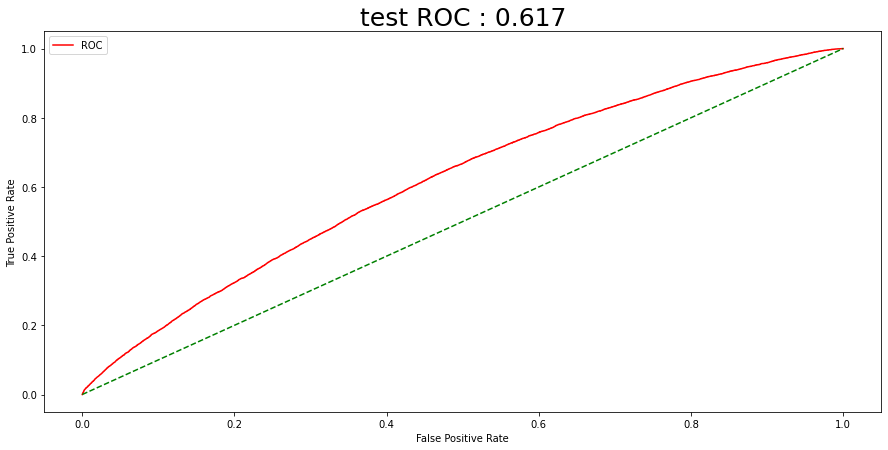

train_f1 score:  0.38492837161990334
test_f1 score:  0.35233762951731107 

train_recall score:  0.5712788040173611
test_recall score:  0.5446519259317134 

train_pre score:  0.29024938479402584
test_pre score:  0.2603937096111464 

train acc score:  0.6604042917484078
test acc score:  0.6043107707509882 



In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=5,
                   n_estimators=1000,
                   ) # 임의의 값 (튜닝값 x)

xgb_model.fit(trainX, trainY)

train_prob = xgb_model.predict_proba(trainX)[:, 1]
train_pred = xgb_model.predict(trainX)
test_prob = xgb_model.predict_proba(testX)[:, 1]
test_pred = xgb_model.predict(testX)

plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)

### 모델 저장 

In [11]:
import pickle
pickle.dump(xgb_model, open('xgb.model', 'wb'))

--------

### 모델 로드 

In [12]:
xgb_model = pickle.load(open('xgb.model', 'rb'))

train_prob = xgb_model.predict_proba(trainX)[:, 1]
train_pred = xgb_model.predict(trainX)
test_prob = xgb_model.predict_proba(testX)[:, 1]
test_pred = xgb_model.predict(testX)

# Shap Value

### 컬럼 리스트

In [13]:
# 컬럼 리스트 생성
lst_col_info = []

for day in range(9, -1, -1): 
    lst_col_info += 'D-{0}_Open,D-{0}_High,D-{0}_Low,D-{0}_Close,D-{0}_Trading,D-{0}_MA5,D-{0}_MA20,D-{0}_MA60,D-{0}_MA120,D-{0}_VMAP,D-{0}_BHB,D-{0}_BLB,D-{0}_KCH,D-{0}_KCL,D-{0}_KCM,D-{0}_DCH,D-{0}_DCL,D-{0}_DCM,D-{0}_SMA,D-{0}_EMA,D-{0}_WMA,D-{0}_Ichimoku,D-{0}_Parabolic SAR,D-{0}_KAMA,D-{0}_MACD,D-{0}_Change,D-{0}_Volume,D-{0}_MFI,D-{0}_ADI,D-{0}_OBV,D-{0}_CMF,D-{0}_FI,D-{0}_EOM_EMV,D-{0}_VPT,D-{0}_NVI,D-{0}_ATR,D-{0}_UI,D-{0}_ADX,D-{0}_-VI,D-{0}_+VI,D-{0}_TRIX,D-{0}_MI,D-{0}_CCI,D-{0}_DPO,D-{0}_KST,D-{0}_STC,D-{0}_RSI,D-{0}_SRSI,D-{0}_TSI,D-{0}_UO,D-{0}_SR,D-{0}_WR,D-{0}_AO,D-{0}_ROC,D-{0}_PPO,D-{0}_PVO'.format(day).split(',')

### numpy -> dataframe 

In [14]:
##### train
df_trainX = pd.DataFrame(trainX)
df_trainX.columns = lst_col_info
df_trainY = pd.DataFrame(trainY)

##### test 
df_testX = pd.DataFrame(testX)
df_testX.columns = lst_col_info
df_testY = pd.DataFrame(testY)

##### train + test
df_dataX = pd.DataFrame(dataX)
df_dataX.columns = lst_col_info
df_dataY = pd.DataFrame(dataY)

df_trainX.head()

,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,D-9_TSI,D-9_UO,...,D-0_MA20,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
0,1.014235,1.014235,0.990510,1.002372,50865.391459,1.012100,1.039442,1.004251,1.067230,1.062162,1.098787,0.980098,1.074990,1.007849,1.041420,1.103203,0.990510,1.037960,1.044682,1.029149,1.021405,1.041518,1.076054,1.020983,0.001305,0.002372,50745.0,62.019387,1.777652e+06,21442201.0,-0.031398,-6.234345e+05,0.000000e+00,-332.722659,757.300473,279.968549,4.171082,22.208911,1.115385,0.943590,0.183742,24.748562,-99.823098,367.5,58.577256,3.125000,41.595415,0.029542,2.234251,35.384663,...,0.972907,0.939482,0.984967,0.977658,1.028984,0.916831,1.006094,0.941557,0.973825,1.031938,0.916300,0.974119,0.968337,0.982715,0.992854,0.974119,0.991081,0.972808,0.012970,0.033040,187215.0,78.677636,1.855011e+06,21559556.0,-0.057511,1.281236e+07,3.458590e+07,9300.710880,765.876922,300.049951,4.781368,22.592942,0.931973,1.056689,0.118438,25.457143,142.316867,-334.0,26.316628,92.875305,67.826155,1.000000,14.884190,55.338001,100.952381,0.952381,223.411765,10.613208,1.337481,6.227088
1,0.984615,1.023669,0.984615,0.997633,55152.152663,1.000947,1.036391,1.002367,1.063619,1.055599,1.096905,0.975876,1.072446,1.004280,1.038363,1.100592,0.984615,1.033728,1.035306,1.022239,1.011887,1.038166,1.064973,1.012171,-0.001114,-0.002367,55283.0,51.786513,1.759224e+06,21386918.0,-0.030704,-6.923238e+05,2.089250e+07,-10.455878,757.300473,283.542224,4.647229,21.393924,1.136483,0.887139,0.151700,24.836716,-91.178651,192.5,51.439154,1.562500,40.946789,0.007841,-0.634199,34.974557,...,0.944350,0.910856,0.953198,0.950598,1.005155,0.883544,0.975409,0.914534,0.944972,1.012793,0.886994,0.949893,0.945629,0.959599,0.972329,0.950693,0.959384,0.956361,0.015937,0.005330,105149.0,84.843280,1.862021e+06,21664705.0,-0.024944,1.173309e+07,3.423713e+07,6746.013357,769.959421,289.332097,4.682768,24.144421,0.881797,1.160757,0.140746,25.405072,182.131974,-428.0,30.971582,96.437652,68.784853,1.000000,18.642720,51.178165,94.067797,-5.932203,310.029412,10.941176,1.688808,4.010564
2,0.990510,1.064057,0.990510,1.026097,78619.572954,1.007355,1.039739,1.005575,1.065055,1.054236,1.099087,0.980391,1.077422,1.005892,1.041657,1.103203,0.986951,1.036180,1.034796,1.024885,1.013892,1.039739,1.067499,1.015549,-0.000920,0.026097,76620.0,47.411891,1.756752e+06,21463538.0,-0.029523,1.814637e+06,1.416079e+08,1868.725616,757.300473,307.574922,4.850647,20.798003,1.055690,0.866828,0.124766,25.103301,-38.102525,265.0,45.148232,0.781250,50.154514,0.331171,-0.534433,36.657246,...,0.943160,0.907971,0.948206,0.958880,1.016118,0.870202,0.974973,0.910710,0.942842,1.033934,0.882291,0.959703,0.952280,0.966730,0.982774,0.966066,0.954297,0.974211,0.021014,0.033934,316499.0,91.415626,2.178520e+06,21981204.0,0.104211,2.452546e+07,8.688811e+06,11300.652682,769.959421,307.951233,4.278775,26.173897,0.817757,1.170561,0.173342,25.410292,197.361375,-444.0,40.165633,98.218826,74.103331,1.000000,23.963771,66.127796,100.000000,-0.000000,393.558824,15.658363,2.221982,14.120940
3,0.996532,1.040462,0.996532,1.038150,210838.980347,0.992832,1.016358,0.980732,1.037177,1.021560,1.072626,0.960091,1.053391,0.981599,1.017495,1.075145,0.961850,1.008092,1.007996,1.004869,0.996326,1.011850,1.04

### shap value 계산 

In [15]:
##### train
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(df_trainX)
shap_values_test = explainer.shap_values(df_testX)
shap_values_data = explainer.shap_values(df_dataX)

### shap_value 데이터프레임 생성 

In [16]:
##### train
df_shap = pd.DataFrame(shap_values)
df_shap.columns = lst_col_info

##### test
df_shap_test = pd.DataFrame(shap_values_test)
df_shap_test.columns = lst_col_info

##### train + test
df_shap_data = pd.DataFrame(shap_values_data)
df_shap_data.columns = lst_col_info

#### df가 맞는지 확인  - 절댓값 씌운 후 컬럼 별 합 내림차순 정렬이 summary plot과 같은지 확인 

In [17]:
pd.DataFrame(df_shap.apply(lambda x: abs(x)).sum().sort_values(ascending=False)).head(10)

,0
D-0_High,32570.941406
D-0_KCL,29476.691406
D-0_DCH,25993.482422
D-0_Close,8176.165527
D-0_MA120,7555.042480
D-0_SR,5032.458496
D-0_Trading,4896.016113
D-0_MA5,4454.119141
D-0_PVO,4443.583008
D-4_Low,4416.430664


## summary plot

### train

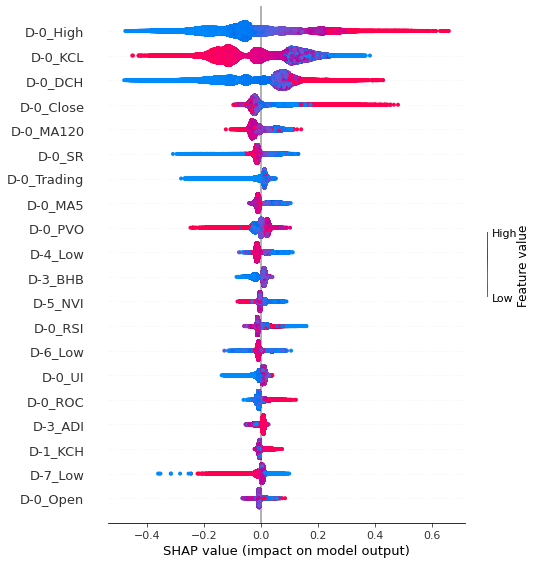

In [18]:
shap.summary_plot(shap_values, df_trainX)

### test 

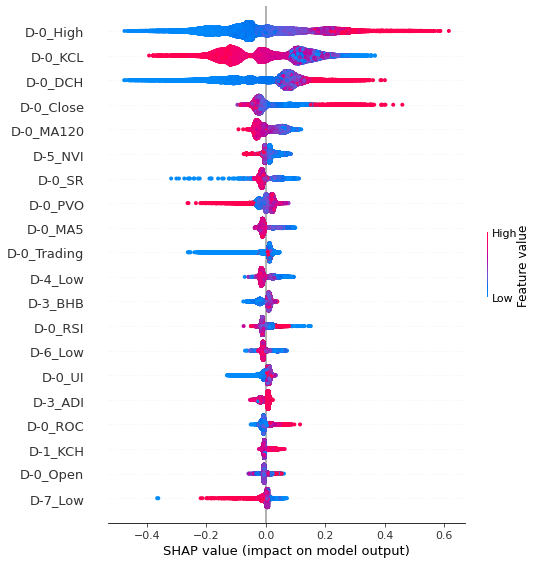

In [19]:
shap.summary_plot(shap_values_test, df_testX)

### train + test 

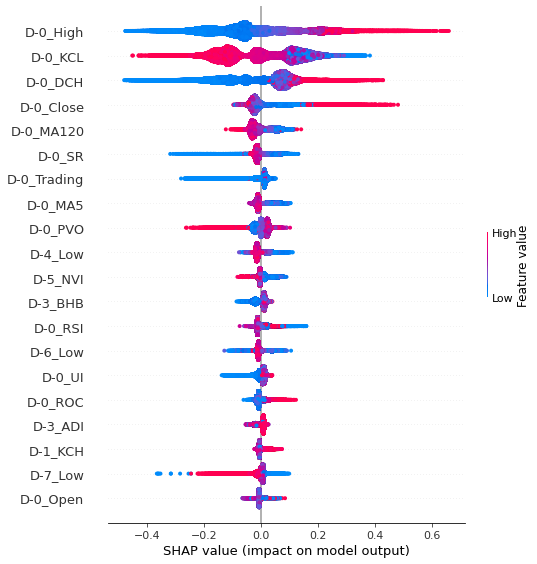

In [20]:
shap.summary_plot(shap_values_data, df_dataX)

--------

# TSNE -  original 데이터 
- (row num) x 560 -> (row num) x 2  

- 공식문서: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- 예제 참고: https://jimmy-ai.tistory.com/126

In [21]:
from sklearn.manifold import TSNE

## Train

In [22]:
# 2차원 t-sne 임베딩
np_tsne = TSNE(n_components=2).fit_transform(df_trainX)

# numpy array -> Dataframe 
df_tsne = pd.DataFrame(np_tsne, columns=['component0', 'component1'])

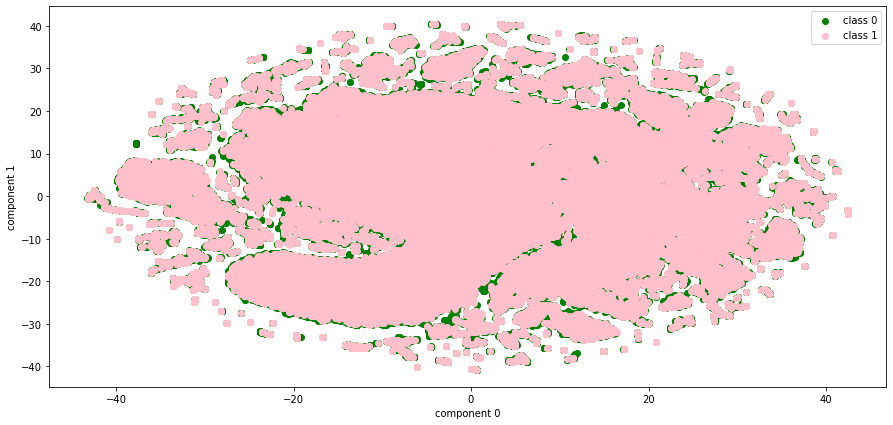

In [23]:
# class target 정보 불러오기
df_tsne['target'] = df_trainY[0]

# target 별 분리 
df_tsne_0 = df_tsne[df_tsne['target']==0]
df_tsne_1 = df_tsne[df_tsne['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_0['component0'], df_tsne_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_1['component0'], df_tsne_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

## Test 

In [24]:
# 2차원 t-sne 임베딩
np_tsne_test = TSNE(n_components=2).fit_transform(df_testX)

# numpy array -> Dataframe 
df_tsne_test = pd.DataFrame(np_tsne_test, columns=['component0', 'component1'])

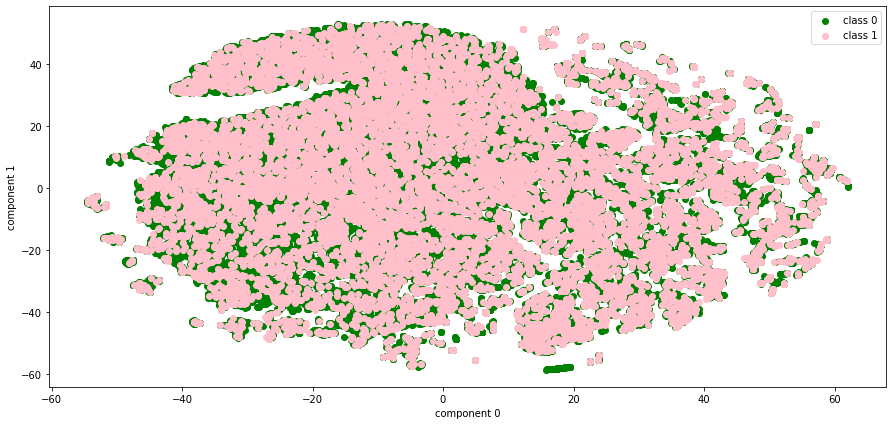

In [25]:
# class target 정보 불러오기
df_tsne_test['target'] = df_testY[0]

# target 별 분리 
df_tsne_test_0 = df_tsne_test[df_tsne_test['target']==0]
df_tsne_test_1 = df_tsne_test[df_tsne_test['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_test_0['component0'], df_tsne_test_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_test_1['component0'], df_tsne_test_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [26]:
# 2차원 t-sne 임베딩
np_tsne_test = TSNE(n_components=3).fit_transform(df_testX)

# numpy array -> Dataframe 
df_tsne_test = pd.DataFrame(np_tsne_test, columns=['component0', 'component1', 'component2'])

## Train + Test 

In [27]:
# 2차원 t-sne 임베딩
np_tsne_data = TSNE(n_components=2, n_jobs=30).fit_transform(df_dataX)

# numpy array -> Dataframe 
df_tsne_data = pd.DataFrame(np_tsne_data, columns=['component0', 'component1'])

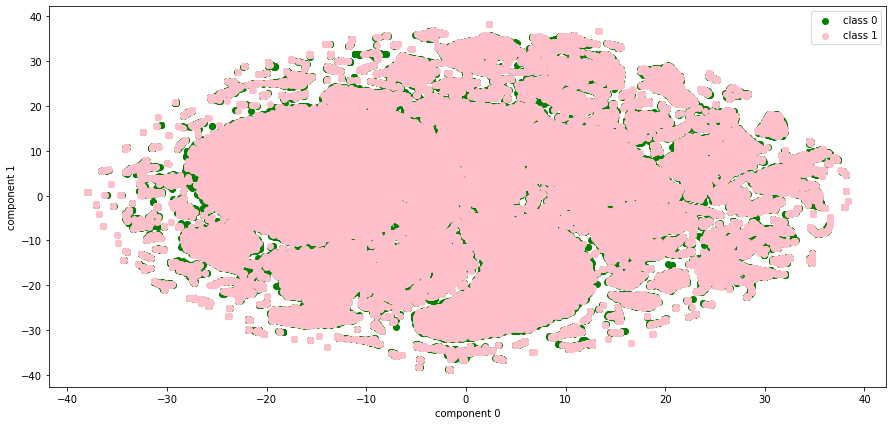

In [28]:
# class target 정보 불러오기
df_tsne_data['target'] = df_dataY[0]

# target 별 분리 
df_tsne_data_0 = df_tsne_data[df_tsne_data['target']==0]
df_tsne_data_1 = df_tsne_data[df_tsne_data['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_data_0['component0'], df_tsne_data_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_data_1['component0'], df_tsne_data_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

# TSNE - shap value 데이터 
- (row num) x 560 -> (row num) x 2  

## Train

In [29]:
# 2차원 t-sne 임베딩
np_tsne_shap = TSNE(n_components=2).fit_transform(df_shap)

# numpy array -> Dataframe 
df_tsne_shap = pd.DataFrame(np_tsne_shap, columns=['component0', 'component1'])

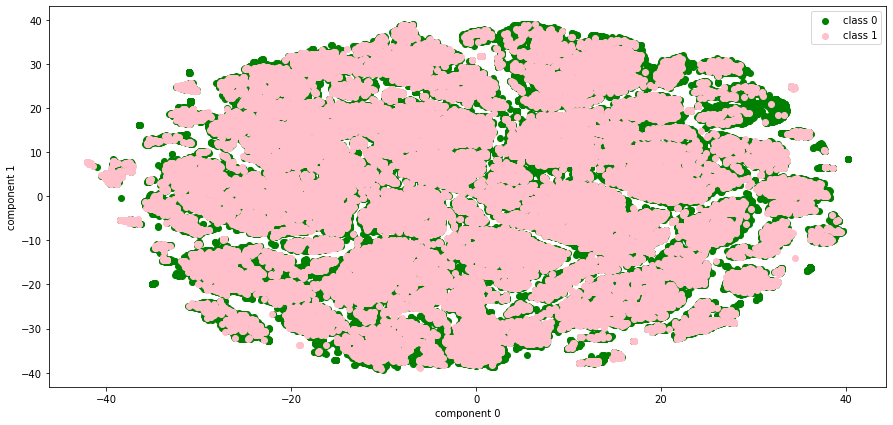

In [30]:
# class target 정보 불러오기
df_tsne_shap['target'] = df_trainY[0]

# target 별 분리 
df_tsne_shap_0 = df_tsne_shap[df_tsne_shap['target']==0]
df_tsne_shap_1 = df_tsne_shap[df_tsne_shap['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_shap_0['component0'], df_tsne_shap_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_shap_1['component0'], df_tsne_shap_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [31]:
df_trainY

,0
0,0
1,1
2,0
3,0
4,0
...,...
256394,1
256395,1
256396,0
256397,0


## Test 

In [32]:
# 2차원 t-sne 임베딩
np_tsne_shap_test = TSNE(n_components=2).fit_transform(df_shap_test)

# numpy array -> Dataframe 
df_tsne_shap_test = pd.DataFrame(np_tsne_shap_test, columns=['component0', 'component1'])

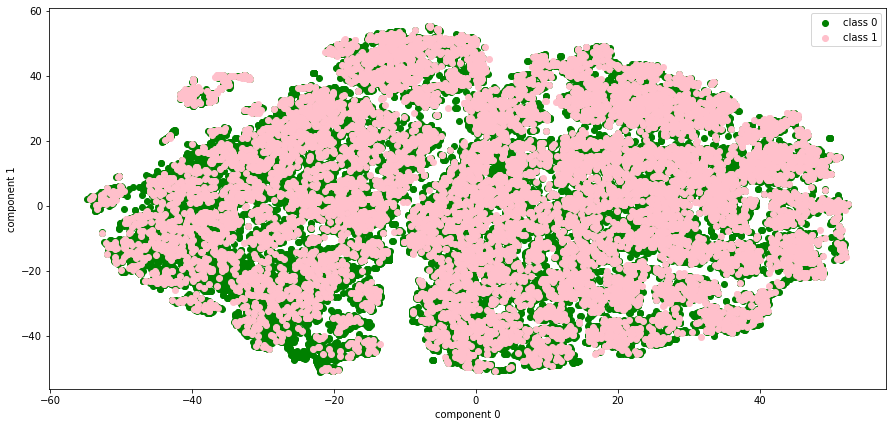

In [33]:
# class target 정보 불러오기
df_tsne_shap_test['target'] = df_testY[0]

# target 별 분리 
df_tsne_shap_test_0 = df_tsne_shap_test[df_tsne_shap_test['target']==0]
df_tsne_shap_test_1 = df_tsne_shap_test[df_tsne_shap_test['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_shap_test_0['component0'], df_tsne_shap_test_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_shap_test_1['component0'], df_tsne_shap_test_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

## Train + Test 

In [34]:
# 2차원 t-sne 임베딩
np_tsne_shap_data = TSNE(n_components=2, n_jobs=30).fit_transform(df_shap_data)

# numpy array -> Dataframe 
df_tsne_shap_data = pd.DataFrame(np_tsne_shap_data, columns=['component0', 'component1'])

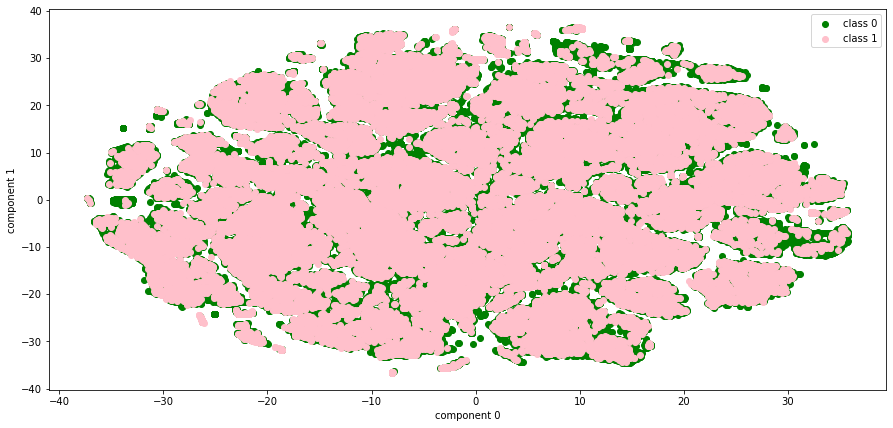

In [35]:
# class target 정보 불러오기
df_tsne_shap_data['target'] = df_dataY[0]

# target 별 분리 
df_tsne_shap_data_0 = df_tsne_shap_data[df_tsne_shap_data['target']==0]
df_tsne_shap_data_1 = df_tsne_shap_data[df_tsne_shap_data['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_shap_data_0['component0'], df_tsne_shap_data_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_shap_data_1['component0'], df_tsne_shap_data_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

# TSNE - 가중치 거리 데이터 
- (row num) x (row num) -> (row num) x 2  

- 각 변수의 shap value를 가중치로 두어 거리를 계산한 후 tsne 진행 

In [36]:
np_weights = (df_shap.apply(lambda x: abs(x)).sum()).values
np_weights_test = (df_shap_test.apply(lambda x: abs(x)).sum()).values
np_weights_data = (df_shap_data.apply(lambda x: abs(x)).sum()).values

## Train

In [38]:
from itertools import combinations

np_tmp = np.zeros(shape=(5000, 5000)) # len(array) x len(array) 크기의 numpy 생성
shap_trainX = np.array(df_shap)

for i in tqdm(range(5000)):
    for j in range(i+1, 5000):
        dis = np.sqrt(np.sum(np_weights * ((trainX[i] - trainX[j])**2))) # 가중거리 계산
        np_tmp[i][j] = dis
        np_tmp[j][i] = dis
    
df_dis_train = pd.DataFrame(np_tmp)

100%|█████████████████████████████████████████████████████████| 5000/5000 [01:57<00:00, 42.67it/s]


In [39]:
# 2차원 t-sne 임베딩
np_tsne_dis = TSNE(n_components=2, n_jobs=40).fit_transform(df_dis_train)

# numpy array -> Dataframe 
df_tsne_dis = pd.DataFrame(np_tsne_dis, columns=['component0', 'component1'])

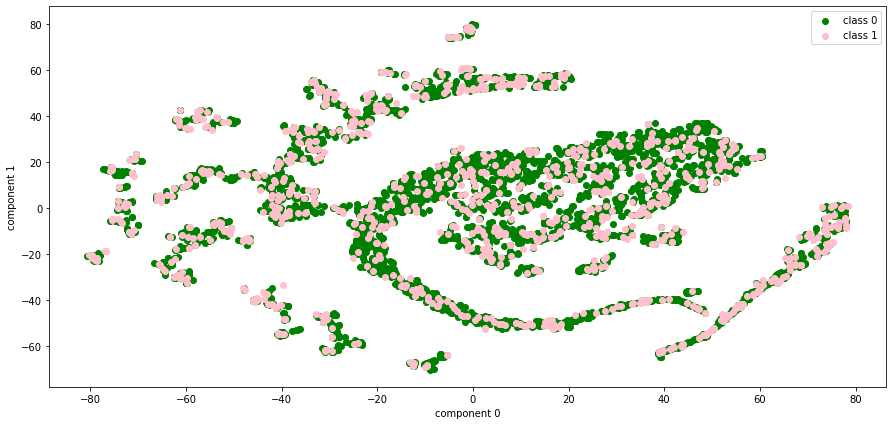

In [40]:
# class target 정보 불러오기
df_tsne_dis['target'] = df_trainY[0]

# target 별 분리 
df_tsne_dis_0 = df_tsne_dis[df_tsne_dis['target']==0]
df_tsne_dis_1 = df_tsne_dis[df_tsne_dis['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_dis_0['component0'], df_tsne_dis_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_dis_1['component0'], df_tsne_dis_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

## Test 

In [41]:
from itertools import combinations

np_tmp = np.zeros(shape=(5000, 5000)) # len(array) x len(array) 크기의 numpy 생성
shap_testX = np.array(df_shap_test)

for i in tqdm(range(5000)):
    for j in range(i+1, 5000):
        dis = np.sqrt(np.sum(np_weights_test * ((testX[i] - testX[j])**2))) # 가중거리 계산
        np_tmp[i][j] = dis
        np_tmp[j][i] = dis
    
df_dis_test = pd.DataFrame(np_tmp)

100%|█████████████████████████████████████████████████████████| 5000/5000 [01:56<00:00, 42.80it/s]


In [42]:
# 2차원 t-sne 임베딩
np_tsne_dis_test = TSNE(n_components=2, n_jobs=40).fit_transform(df_dis_test)

# numpy array -> Dataframe 
df_tsne_dis_test = pd.DataFrame(np_tsne_dis_test, columns=['component0', 'component1'])

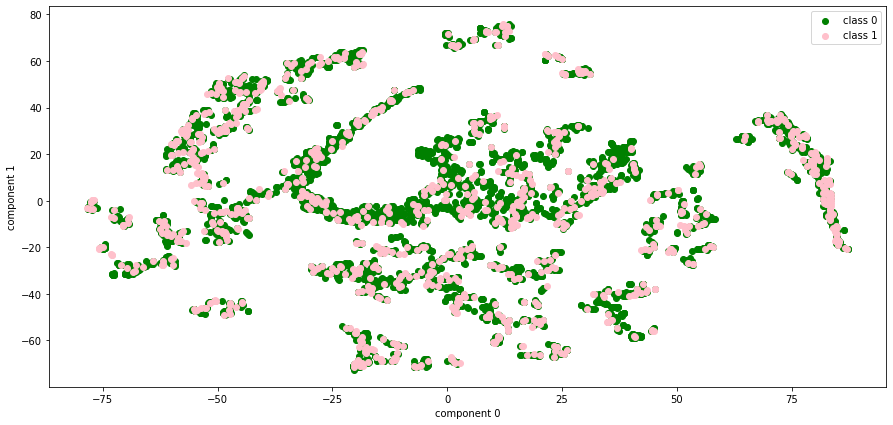

In [43]:
# class target 정보 불러오기
df_tsne_dis_test['target'] = df_testY[0]

# target 별 분리 
df_tsne_dis_test_0 = df_tsne_dis_test[df_tsne_dis_test['target']==0]
df_tsne_dis_test_1 = df_tsne_dis_test[df_tsne_dis_test['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_dis_test_0['component0'], df_tsne_dis_test_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_dis_test_1['component0'], df_tsne_dis_test_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

## train + test

In [44]:
from itertools import combinations

np_tmp = np.zeros(shape=(5000, 5000)) # len(array) x len(array) 크기의 numpy 생성
shap_dataX = np.array(df_shap_data)

for i in tqdm(range(5000)):
    for j in range(i+1, 5000):
        dis = np.sqrt(np.sum(np_weights_test * ((dataX[i] - dataX[j])**2))) # 가중거리 계산
        np_tmp[i][j] = dis
        np_tmp[j][i] = dis
    
df_dis_data = pd.DataFrame(np_tmp)

100%|█████████████████████████████████████████████████████████| 5000/5000 [01:57<00:00, 42.62it/s]


In [46]:
# 2차원 t-sne 임베딩
np_tsne_dis_data = TSNE(n_components=2, n_jobs=40).fit_transform(df_dis_data)

# numpy array -> Dataframe 
df_tsne_dis_data = pd.DataFrame(np_tsne_dis_data, columns=['component0', 'component1'])

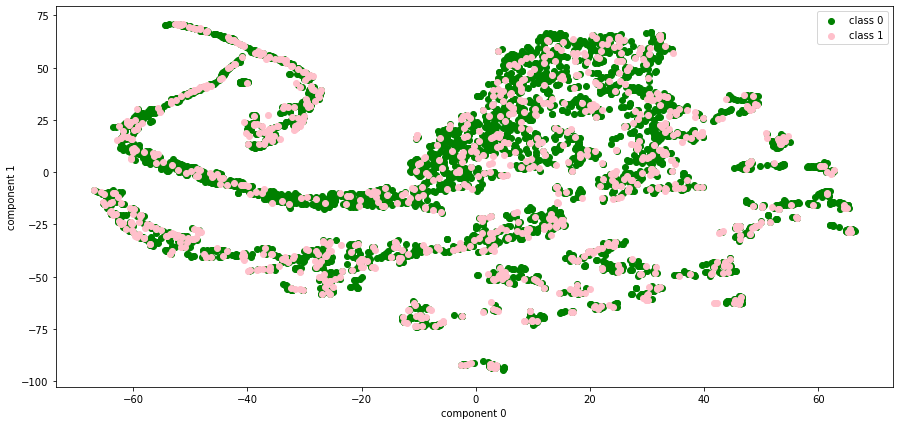

In [47]:
# class target 정보 불러오기
df_tsne_dis_data['target'] = df_dataY[0]

# target 별 분리 
df_tsne_dis_data_0 = df_tsne_dis_data[df_tsne_dis_data['target']==0]
df_tsne_dis_data_1 = df_tsne_dis_data[df_tsne_dis_data['target']==1]

# target 별 시각화 
plt.scatter(df_tsne_dis_data_0['component0'], df_tsne_dis_data_0['component1'], color = 'green', label = 'class 0')
plt.scatter(df_tsne_dis_data_1['component0'], df_tsne_dis_data_1['component1'], color = 'pink', label = 'class 1')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

-------------------

##### 멀티 프로세싱  (미완성)

- 가중거리 계산 시간을 줄이기 위하여 
- multiprocessiong 예제 참고: https://niceman.tistory.com/145
- su - 사용자명 -c 'kill -9 -1' (프로세스 kill )

In [ ]:
np_tmp = np.zeros(shape=(3, 3)) # len(array) x len(array) 크기의 numpy 생성

def matrix_weighted_distance(i):

    for j in range(i+1, 3):
        dis = np.sqrt(np.sum(np_weights_test * ((testX[i] - testX[j])**2))) # 가중거리 계산
        np_tmp[i][j] = dis
        np_tmp[j][i] = dis 


In [ ]:
##############################################
import multiprocessing
from itertools import combinations 
import time


start_time = time.time()
pool = multiprocessing.Pool(processes=40) # 프로세스 개수
print('multiprocessing start')

pool.map(matrix_weighted_distance, list(range(3))) # array 지정


mid_time = time.time()
print(f'multiprocessing: {(mid_time - start_time)/60} 분')
pool.close()
pool.join()
print(f'close & join: {(time.time() - mid_time)/60} 분')

In [ ]:
np_tmp

--------------

In [ ]:
np_tmp = np.zeros(shape=(len(testX), len(testX))) # len(array) x len(array) 크기의 numpy 생성

def matrix_weighted_distance(i):

    for j in range(i+1, len(testX)):
        dis = np.sqrt(np.sum(np_weights_test * ((testX[i] - testX[j])**2))) # 가중거리 계산
        np_tmp[i][j] = dis
        np_tmp[j][i] = dis 
        

In [ ]:
##############################################
import multiprocessing
from itertools import combinations 
import time


start_time = time.time()
pool = multiprocessing.Pool(processes=40) # 프로세스 개수
print('multiprocessing start')

pool.map(matrix_weighted_distance, range(len(testX))) 
    
mid_time = time.time()
print(f'multiprocessing: {(mid_time - start_time)/60} 분')
pool.close()
pool.join()
print(f'close & join: {(time.time() - mid_time)/60} 분')